In [1]:
include("../src/GaPSE.jl");
using DelimitedFiles, Plots

In [2]:
FILE_F_MAP = "../data/F_REFERENCE.txt"
FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"
FILE_IS = "tab_xi.txt"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70)
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IS)

GaPSE.parameters_used(stdout, cosmo)

# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "../data/WideA_ZA_pk.dat"
# F window function input file : "../data/F_REFERENCE.txt"
# CLASS Background input file: "../data/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001343431 Mpc/h_0
# 	 comoving s_max = 571.7022420911966 Mpc/h_0
# 	 comoving s_eff = 435.37470960794167 Mpc/h_0
# 	 comoving z_eff = 0.15045636097417317 
# 	 Volume of the survey V_survey = 3.845366169354268e8
# 	 σ_0 = 27.075526807492697
# 	 σ_1 = 16.356260871950333
# 	 σ_2 = 101.10788255943426
# 	 σ_3 = 27.075526807492697
# 


In [3]:
casto_tab = readdlm("tab_kappa_terms.dat", comments=true);
casto_ss = convert(Vector{Float64}, casto_tab[3:end,1]);
casto_xis = convert(Vector{Float64}, casto_tab[3:end,2]);

In [4]:
GaPSE.print_map_int_on_mu(cosmo, 
    "Lensing_test_files/xi_lensing_1.txt", 
    "auto_lensing"; use_windows = false, 
    N_χs = 50, Δχ_min = 1e-3, enhancer=1e10, use_my=false, μ_atol=1e-5, μ_rtol=1e-1) 

GaPSE.print_map_int_on_mu(cosmo, 
    "Lensing_test_files/xi_lensing_2.txt", 
    "auto_lensing"; use_windows = false, 
    N_χs = 100, Δχ_min = 1e-4, enhancer=1e10, use_my=false, μ_atol=1e-5, μ_rtol=1e-1) 
GaPSE.print_map_int_on_mu(cosmo, 
    "Lensing_test_files/xi_lensing_3.txt", 
    "auto_lensing"; use_windows = false, 
    N_χs = 150, Δχ_min = 1e-5, enhancer=1e10, use_my=false, μ_atol=1e-5, μ_rtol=1e-1) 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01
Progress: 100%|█████████████████████████████████████████| Time: 0:02:18


I will use quadgk.

time needed for map_integral_on_mu for auto_lensing [in s] = 18.45865297317505
I will use quadgk.

time needed for map_integral_on_mu for auto_lensing [in s] = 61.463752031326294
I will use quadgk.

time needed for map_integral_on_mu for auto_lensing [in s] = 138.80509901046753


In [5]:
my_tab_1 = readdlm("Lensing_test_files/xi_lensing_1.txt", comments=true);
my_tab_2 = readdlm("Lensing_test_files/xi_lensing_2.txt", comments=true);
my_tab_3 = readdlm("Lensing_test_files/xi_lensing_3.txt", comments=true);

ss_1 = convert(Vector{Float64}, my_tab_1[:,1]);
xis_1 = convert(Vector{Float64}, my_tab_1[:,2]) ./ 2.0; 
ss_2 = convert(Vector{Float64}, my_tab_2[:,1]);
xis_2 = convert(Vector{Float64}, my_tab_2[:,2]) ./ 2.0; 
ss_3 = convert(Vector{Float64}, my_tab_3[:,1]);
xis_3 = convert(Vector{Float64}, my_tab_3[:,2]) ./ 2.0; 

In [11]:
GaPSE.print_map_int_on_mu(cosmo, 
    "Lensing_test_files/xi_lensing_prova.txt", 
    "auto_lensing"; use_windows = false, 
    N_χs = 30, Δχ_min = 1e-6, enhancer=1e10, use_my=false, μ_atol=1e-5, μ_rtol=1e-1)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


I will use quadgk.

time needed for map_integral_on_mu for auto_lensing [in s] = 5.889880895614624


In [12]:
my_tab_prova = readdlm("Lensing_test_files/xi_lensing_prova.txt", comments=true);
ss_prova = convert(Vector{Float64}, my_tab_prova[:,1]);
xis_prova = convert(Vector{Float64}, my_tab_prova[:,2]) ./ 2.0; 

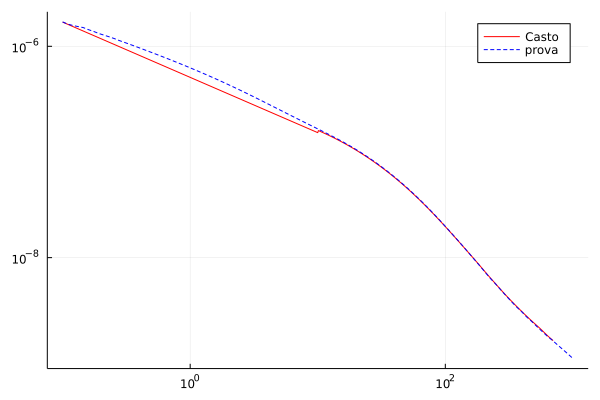

In [13]:
plot([casto_ss, ss_prova[xis_prova.>0.]], 
    [casto_xis, xis_prova[xis_prova.>0.]], 
    xaxis=:log, yaxis=:log, 
    label=["Casto" "prova"], 
    lc=[:red :blue ],
    ls = [:solid :dash])

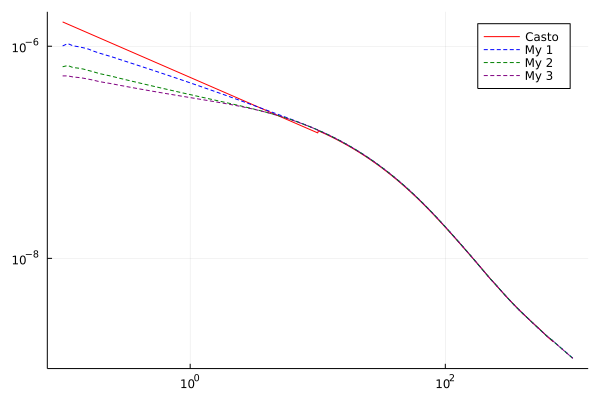

In [9]:
plot([casto_ss, ss_1[xis_1.>0.], ss_2[xis_2.>0.], ss_3[xis_3.>0.]], 
    [casto_xis, xis_1[xis_1.>0.], xis_2[xis_2.>0.], xis_3[xis_3.>0.]], 
    xaxis=:log, yaxis=:log, 
    label=["Casto" "My 1" "My 2" "My 3"], 
    lc=[:red :blue :green :purple],
    ls = [:solid :dash :dash :dash])

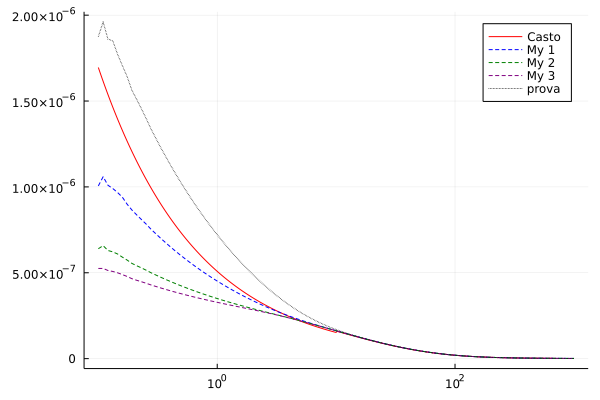

In [10]:
plot([casto_ss, ss_1, ss_2, ss_3, ss_prova], 
    [casto_xis, xis_1, xis_2, xis_3, xis_prova], 
    xaxis=:log, #yaxis=:log, 
    label=["Casto" "My 1" "My 2" "My 3" "prova"], 
    lc=[:red :blue :green :purple :black],
    ls = [:solid :dash :dash :dash :dot])

In [ ]:
GaPSE.ξ_lensing(cosmo.s_eff, cosmo.s_eff + 1.0, 1.0, cosmo)

In [ ]:
xs = -1:0.01:1
ys = [GaPSE.ξ_lensing(cosmo.s_eff, cosmo.s_eff + 1.0, x, cosmo) for x in xs]
plot(xs, ys)